<a href="https://colab.research.google.com/github/deepshah1300/DL/blob/main/Experiment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [2]:
!wget http://upscfever.com/datasets/flowers-new.zip

--2021-03-31 15:22:36--  http://upscfever.com/datasets/flowers-new.zip
Resolving upscfever.com (upscfever.com)... 104.21.90.10, 172.67.193.2, 2606:4700:3033::ac43:c102, ...
Connecting to upscfever.com (upscfever.com)|104.21.90.10|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://upscfever.com/datasets/flowers-new.zip [following]
--2021-03-31 15:22:37--  https://upscfever.com/datasets/flowers-new.zip
Connecting to upscfever.com (upscfever.com)|104.21.90.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘flowers-new.zip’

flowers-new.zip         [           <=>      ]   5.74M  2.43MB/s    in 2.4s    

2021-03-31 15:22:40 (2.43 MB/s) - ‘flowers-new.zip’ saved [6021364]



In [3]:
!unzip flowers-new.zip


Archive:  flowers-new.zip
   creating: flowers/
   creating: flowers/daisy/
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/11642632_1e7627a2cc.jpg  
  inflating: flowers/daisy/15207766_fc2f1d692c_n.jpg  
  inflating: flowers/daisy/21652746_cc379e0eea_m.jpg  
  inflating: flowers/daisy/25360380_1a881a5648.jpg  
  inflating: flowers/daisy/43474673_7bb4465a86.jpg  
  inflating: flowers/daisy/54377391_15648e8d18.jpg  
  inflating: flowers/daisy/5547758_eea9edfd54_n.jpg  
  inflating: flowers/daisy/5673551_01d1ea993e_n.jpg  
  inflating: flowers/daisy/5673728_71b8cb57eb.jpg  
  inflating: flowers/daisy/5794835_d15905c7c8_n.jpg  
  inflating: flowers/daisy/5794839_200acd910c_n.jpg  
  inflating: flowers/daisy/99306615_739eb94b9e_m.jpg  
   creating: flowers/dandelion/
  inflating: flowers/dandelion/10443973_aeb97513fc_m.jpg  
  inflating: flowers/dandelion/10683189_bd6e371b97.jpg  
  inflating: flowers/dandelion/10919961_0af657c4e8.jpg  
  inflating: flowe

### Making the functions to get the training and validation set from the Images

In [4]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='flowers/daisy'
FLOWER_SUNFLOWER_DIR='flowers/sunflower'
FLOWER_TULIP_DIR='flowers/tulip'
FLOWER_DANDI_DIR='flowers/dandelion'
FLOWER_ROSE_DIR='flowers/rose'

In [5]:
flower_dirs = [FLOWER_DAISY_DIR, FLOWER_SUNFLOWER_DIR, FLOWER_TULIP_DIR, FLOWER_DANDI_DIR, FLOWER_ROSE_DIR]

In [6]:
flowers = ['Daisy', 'Sunflower', 'Tulip', 'Dandelion', 'Rose']

In [7]:
def generate_images(flower, DIR, num=10):
  for img in tqdm(os.listdir(DIR)):
    img = cv2.imread(DIR + '/' + img)
    img = img.reshape((1,) + img.shape)

    gen_datagen = ImageDataGenerator(
          rotation_range=90,  
          zoom_range = 0.3, 
          width_shift_range=0.2,
          height_shift_range=0.2,
          horizontal_flip=True,
          vertical_flip=True,
          brightness_range=[0.5,1.5],
          shear_range=0.2
    )

    for idx, image_save in enumerate((gen_datagen.flow(img, 
                                                      batch_size=1, 
                                                      save_to_dir = DIR + '/', save_prefix=flower,
                                                      save_format='jpg'))):
      if idx == 30:
        break

In [8]:
for flower, flower_dir in zip(flowers, flower_dirs):
  generate_images(flower, flower_dir)

100%|██████████| 26/26 [00:27<00:00,  1.06s/it]


In [9]:
len(os.listdir(FLOWER_DAISY_DIR))

410

In [10]:
def make_train_data(flower_type,DIR):
    for img in os.listdir(DIR):
        
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(flower_type))

In [11]:
for flower, flower_dir in zip(flowers, flower_dirs):
  make_train_data(flower, flower_dir)

In [12]:
for flower_dir in flower_dirs:
  print(str(len(os.listdir(flower_dir))) + flower_dir)

410flowers/daisy
796flowers/sunflower
801flowers/tulip
803flowers/dandelion
801flowers/rose


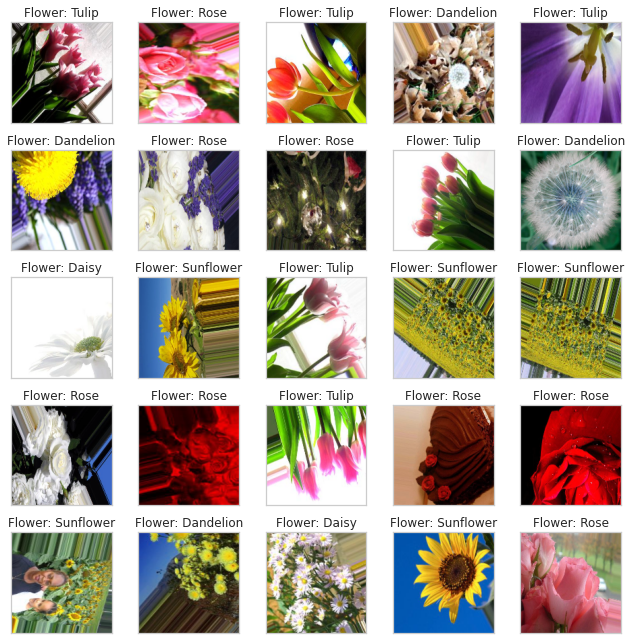

In [13]:
fig, ax = plt.subplots(5,5)
fig.set_size_inches(9,9)

for i in range(5):
  for j in range(5):

    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])

    l = rn.randint(0,len(Z))
    ax[i][j].imshow(X[l])
    ax[i][j].title.set_text('Flower: '+ Z[l])
    
plt.tight_layout()


In [14]:
len(X)

3611

In [15]:
len(Z)

3611

### Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [16]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

### Splitting into Training and Validation Sets

In [17]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

### Setting the Random Seeds

In [18]:
np.random.seed(42)
rn.seed(42)


### Building the ANN

In [19]:
import tensorflow as tf 
from tensorflow import keras 
import matplotlib.pyplot as plt 


In [20]:
model = keras.Sequential([keras.layers.Flatten(input_shape=(150,150,3)),
                          keras.layers.Dense(128,activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                          keras.layers.Dense(64,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                          keras.layers.Dense(32,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                          keras.layers.Dense(5)])

In [21]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Building ANN Model 

In [22]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

rd = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=55, verbose=1, mode='auto')
filepath='regularized_weight_{epoch:02d}_{val_loss:.2f}.h5'
mc = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [23]:
history = model.fit(x_train,y_train, batch_size=100, validation_split=0.2, epochs = 100, verbose = 2, callbacks=[rd, es, mc])

Epoch 1/100
22/22 - 4s - loss: 7.1796 - accuracy: 0.2692 - val_loss: 2.1725 - val_accuracy: 0.3875

Epoch 00001: val_loss improved from inf to 2.17253, saving model to regularized_weight_01_2.17.h5
Epoch 2/100
22/22 - 3s - loss: 2.3645 - accuracy: 0.3689 - val_loss: 2.0285 - val_accuracy: 0.4520

Epoch 00002: val_loss improved from 2.17253 to 2.02850, saving model to regularized_weight_02_2.03.h5
Epoch 3/100
22/22 - 3s - loss: 1.9782 - accuracy: 0.4594 - val_loss: 1.8242 - val_accuracy: 0.4797

Epoch 00003: val_loss improved from 2.02850 to 1.82418, saving model to regularized_weight_03_1.82.h5
Epoch 4/100
22/22 - 3s - loss: 1.7295 - accuracy: 0.5078 - val_loss: 2.0865 - val_accuracy: 0.4410

Epoch 00004: val_loss did not improve from 1.82418
Epoch 5/100
22/22 - 3s - loss: 1.7288 - accuracy: 0.5037 - val_loss: 1.9621 - val_accuracy: 0.5166

Epoch 00005: val_loss did not improve from 1.82418
Epoch 6/100
22/22 - 3s - loss: 1.7432 - accuracy: 0.5120 - val_loss: 2.2757 - val_accuracy: 0.38

In [24]:
pred = model.evaluate(x_test, y_test)

29/29 [==============================] - 1s 23ms/step - loss: 1.2864 - accuracy: 0.5637


#Add softmax to get predictions

In [25]:
final_model = tf.keras.Sequential([
                                   model,
                                   tf.keras.layers.Softmax()
])

In [26]:
predictions = final_model.predict_classes(x_test)

### Saving Model

In [27]:
# save the model to disk
final_model.save('final_model2.h5')

### Loading Model

In [28]:
from tensorflow import keras
model = keras.models.load_model('/content/final_model2.h5')


In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 5)                 8650629   
_________________________________________________________________
softmax (Softmax)            (None, 5)                 0         
Total params: 8,650,629
Trainable params: 8,650,629
Non-trainable params: 0
_________________________________________________________________


#Deployment

In [30]:
!pip install flask gevent requests pillow

     |████████████████████████████████| 5.6MB 8.7MB/s 
     |████████████████████████████████| 256kB 39.1MB/s 


Creat a file ProcFile

In [31]:
procfile = 'web: gunicorn app:app'
procfiles= open("/content/Procfile","w")
procfiles.write(procfile)
procfiles.close()

#Install flask and ngrok

In [32]:
!pip install flask-ngrok
from flask_ngrok import run_with_ngrok
from flask import Flask

#Webpage

In [33]:
a = '''
<!doctype html>
<html lang="en">
<head>
<title>My flower recognizer</title>
</head> 
  <body>
 
          <h3>Image Recognition Server</h3><br/>
       
      <form action="" method="post" enctype=multipart/form-data>
        <input type=file name="flowers"><br/>
        
        <p>daisy = 0</p><br/>
        <p>dandelion = 1</p><br/>
        <p>rose = 2</p><br/>
        <p>sunflower = 3</p><br/>
        <p>tulip = 4</p><br/>
        <p>Enter flower number in text box</p><br/>
        <input type=text name="flower_name">

        <input type=submit value=Upload>
    </form>
    {{label}}  
     
  </body>
  </html>
  '''

In [34]:
!mkdir '/content/templates'
!mkdir '/content/uploads'
!mkdir '/content/uploads/daisy'
!mkdir '/content/uploads/dandelion'
!mkdir '/content/uploads/rose'
!mkdir '/content/uploads/sunflower'
!mkdir '/content/uploads/tulip'

Html_file = open("/content/templates/index.html", "w")
Html_file.write(a)
Html_file.close()

#Deploy model

In [ ]:
import os
from flask import Flask, render_template, request
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array

app = Flask(__name__)
run_with_ngrok(app)
app.config['UPLOADS'] = 'uploads'


def load_mymodel():
    global mymodel
    mymodel = keras.models.load_model('/content/final_model2.h5')
    final_model = tf.keras.Sequential([
                                   mymodel,
                                   tf.keras.layers.Softmax()
    ])
    

@app.route('/')
def home():
    return render_template('index.html')

def predictions(file):
    img = image.load_img(file, target_size=(150,150), color_mode="rgb")
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    ans = final_model.predict_classes(img)
    return ans


@app.route('/', methods=['POST'])
def upload_files():
    file = request.files['flowers']
    flowerslabels = request.form['flower_name']
    print(type(flowerslabels))
    if int(flowerslabels) == 0:
      flowerslabels = 'daisy'
      filepath = os.path.join(app.config['UPLOADS'], flowerslabels, file.filename)
      file.save(filepath)
    elif int(flowerslabels) == 1:
      flowerslabels = 'dandelion'
      filepath = os.path.join(app.config['UPLOADS'], flowerslabels, file.filename)
      file.save(filepath)
    elif int(flowerslabels) == 2:
      flowerslabels = 'rose'
      filepath = os.path.join(app.config['UPLOADS'], flowerslabels, file.filename)
      file.save(filepath)
    elif int(flowerslabels) == 3:
      flowerslabels = 'sunflower'
      filepath = os.path.join(app.config['UPLOADS'], flowerslabels, file.filename)
      file.save(filepath)
    else:
      flowerslabels = 'tulip'
      filepath = os.path.join(app.config['UPLOADS'], flowerslabels, file.filename)
      file.save(filepath)



    output = predictions(filepath)

    if output.astype('int32') == 0:
      output = 'daisy'
    elif output.astype('int32') == 1:
      output = 'dandelion'
    elif output.astype('int32') == 2:
      output = 'rose'
    elif output.astype('int32') == 3:
      output = 'sunflower'
    else:
      output = 'tulip'

    return render_template('index.html', label=output)



if __name__=='__main__':
    load_mymodel()
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
Exception in thread Thread-17:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 1177, in run
    self.function(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.7/dist-packages/flask_ngrok.py", line 70, in start_ngrok
    ngrok_address = _run_ngrok()
  File "/usr/local/lib/python3.7/dist-packages/flask_ngrok.py", line 38, in _run_ngrok
    tunnel_url = j['tunnels'][0]['public_url']  # Do the parsing of the get
IndexError: list index out of range

